In [230]:
IS_KAGGLE = False

if IS_KAGGLE:
    INPUT_FOLDER = '/kaggle/input/linking-writing-processes-to-writing-quality'
else:
    INPUT_FOLDER = '../data'

In [231]:
import pandas as pd
import numpy as np

In [232]:
df_raw_train = pd.read_csv(f'{INPUT_FOLDER}/train_logs.csv')
df_raw_test = pd.read_csv(f'{INPUT_FOLDER}/test_logs.csv')

df_raw_train.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [233]:
df_raw = pd.concat((df_raw_train, df_raw_test)).reset_index(False)

**id** - The unique ID of the essay

**event_id** - The index of the event, ordered chronologically

**down_time** - The time of the down event in milliseconds

**up_time** - The time of the up event in milliseconds

**action_time** - The duration of the event (the difference between down_time and up_time)

**activity** - The category of activity which the event belongs to

- **Nonproduction** - The event does not alter the text in any way

- **Input** - The event adds text to the essay

- **Remove/Cut** - The event removes text from the essay

- **Paste** - The event changes the text through a paste input

- **Replace** - The event replaces a section of text with another string

- **Move From [x1, y1] To [x2, y2]** - The event moves a section of text spanning character index x1, y1 to a new location x2, y2

**down_event** - The name of the event when the key/mouse is pressed

**up_event** - The name of the event when the key/mouse is released

**text_change** - The text that changed as a result of the event (if any)

**cursor_position** - The character index of the text cursor after the event

**word_count** - The word count of the essay after the event

In [235]:
# Creating a new df based on the number of essays
# More features (columns) will be added to this df

df = pd.DataFrame({
    'id': df_raw["id"].unique()
})
df['is_test'] = df['id'].isin(df_raw_test['id'].unique())
df

,id,is_test
0,001519c8,False
1,0022f953,False
2,0042269b,False
3,0059420b,False
4,0075873a,False
...,...,...
2469,ffec5b38,False
2470,fff05981,False
2471,0000aaaa,True
2472,2222bbbb,True


In [236]:
# Calculating the final word count for each essay
df_word = df_raw.groupby("id")['word_count'].max()
df = pd.merge(df, df_word, on="id", how="left")

In [237]:
# Turning milliseconds into minutes
df_raw['current_min'] = df_raw["down_time"]//60000

In [238]:
#Counting the number of events per essay
df_event = df_raw.groupby("id")['event_id'].count()

df = pd.merge(df, df_event, on="id", how="left")
df = df.rename(columns={"event_id": "event_count"})

In [239]:
# Calculating the time spend on writing the essay
df_time = df_raw.groupby("id")['current_min'].max()
df = pd.merge(df, df_time, on="id", how="left")
df = df.rename(columns={"current_min": "writing_time_min"})

In [240]:
# Calculating events per minute
df['events_per_min'] = df["event_count"] / df['writing_time_min']

In [241]:
# Calculating the number of TEXT changes made during the writing process
filter_text_change = df_raw["text_change"]!="NoChange"
df_filtered = df_raw[filter_text_change]
df_text_change = df_filtered.groupby("id")['text_change'].count()

df = pd.merge(df, df_text_change, on="id", how="left")

In [242]:
df = df.rename(columns={"text_change": "text_change_count"})

In [243]:
# Calculating text changes per minute
df['text_changes_per_min'] = df["text_change_count"] / df['writing_time_min']

In [244]:
# Calculating the number of sentences (based on the number of full stops)
sentence_filter = df_raw[(df_raw["text_change"].str.match('\.')) & (df_raw['activity'] != 'Remove/Cut')] 
sentence_filter = df_raw[df_raw["up_event"] == '.']
df_sentence_count = sentence_filter.groupby("id")['text_change'].count()

df = pd.merge(df, df_sentence_count, on="id", how="left")

In [245]:
df = df.rename(columns={"text_change": "sentence_count"})
df['sentence_count'] = df['sentence_count'].fillna(0)

In [246]:
# Calculating total number of different activities
for activity in ['Input', 'Remove/Cut', 'Paste', 'Replace', 'Nonproduction']:
    df_activity_count = df_raw[df_raw['activity'] == activity].groupby("id")['activity'].count()
    column_name = f'{activity}_count'
    df_activity_count.name = column_name
    df = pd.merge(df, df_activity_count, on="id", how="left")
    df[column_name] = df[column_name].fillna(0)

In [247]:
# Pauses
df_raw['IKI'] = df_raw['down_time'] - df_raw.groupby('id')['up_time'].shift(1)
df_raw['IKI'] = df_raw['IKI'].fillna(0)
df_raw['IKI'] = df_raw['IKI'].clip(0)

PAUSE_THRESHOLD = 2000

# Total number of pauses (over 2000 ms) during writing process
pauses_count = df_raw[df_raw['IKI'] > PAUSE_THRESHOLD].groupby('id')['IKI'].count()
pauses_count.name = 'pauses_count'
df = pd.merge(df, pauses_count, on="id", how="left")

In [248]:
# Average duration of a pause
pauses_mean_duration = df_raw[df_raw['IKI'] > PAUSE_THRESHOLD].groupby('id')['IKI'].mean().round(0)
pauses_mean_duration.name = 'pause_mean_duration'
df = pd.merge(df, pauses_mean_duration, on="id", how="left")

In [249]:
# Calculating total time of pauses
pauses_time_sum = df_raw[df_raw['IKI'] > PAUSE_THRESHOLD].groupby('id')['IKI'].sum()
pauses_time_sum.name = 'pauses_time_sum'
df = pd.merge(df, pauses_time_sum, on="id", how="left")

In [250]:
# Calculating writing time in ms
writing_time_ms = df_raw.groupby('id')['up_time'].max()
writing_time_ms.name = 'writing_time_ms'
df = pd.merge(df, writing_time_ms, on="id", how="left")

In [251]:
# Average number of pauses per minute
df['pause_per_min'] = (df["pauses_count"] / df['writing_time_min']).round(2)

# Proportion of pauses during the writing process
df['pauses_share'] = (df["pauses_time_sum"] / df['writing_time_ms']).round(2)

In [254]:
df.head()

,id,is_test,word_count,event_count,writing_time_min,events_per_min,text_change_count,text_changes_per_min,sentence_count,Input_count,Remove/Cut_count,Paste_count,Replace_count,Nonproduction_count,pauses_count,pause_mean_duration,pauses_time_sum,writing_time_ms,pause_per_min,pauses_share
0,001519c8,False,256,2557,30,85.233333,2437,81.233333,21.0,2010,417.0,0.0,7.0,120.0,124.0,9537.0,1182600.0,1801969,4.13,0.66
1,0022f953,False,323,2454,29,84.620690,2200,75.862069,15.0,1938,260.0,1.0,1.0,254.0,80.0,14678.0,1174268.0,1788969,2.76,0.66
2,0042269b,False,404,4136,29,142.620690,3961,136.586207,21.0,3515,439.0,0.0,7.0,175.0,77.0,14431.0,1111167.0,1771669,2.66,0.63
3,0059420b,False,206,1556,23,67.652174,1457,63.347826,13.0,1304,151.0,1.0,1.0,99.0,87.0,8828.0,768075.0,1404469,3.78,0.55
4,0075873a,False,252,2531,27,93.740741,2459,91.074074,23.0,1942,517.0,0.0,0.0,72.0,88.0,11880.0,1045463.0,1662472,3.26,0.63


In [255]:
# calcullating the start and end time of writing and most frequent activity
df_freq = df_raw.groupby("id").agg({
    'down_time': ['min', 'max'],
    'activity': lambda x: x.value_counts().index[0]  
}).reset_index()

In [256]:
df_freq.columns = ['id', 'start_time', 'end_time', 'most_frequent_activity']

In [257]:
df_freq

,id,start_time,end_time,most_frequent_activity
0,0000aaaa,338433,760073,Input
1,001519c8,4526,1801877,Input
2,0022f953,30623,1788842,Input
3,0042269b,4441,1771219,Input
4,0059420b,41395,1404394,Input
...,...,...,...,...
2469,ffb8c745,22467,1791581,Input
2470,ffbef7e5,21732,1799124,Input
2471,ffccd6fd,23482,1959273,Input
2472,ffec5b38,19885,1508335,Input


In [258]:
df = pd.merge(df, df_freq, on="id", how='left')
df.head()

,id,is_test,word_count,event_count,writing_time_min,events_per_min,text_change_count,text_changes_per_min,sentence_count,Input_count,...,Nonproduction_count,pauses_count,pause_mean_duration,pauses_time_sum,writing_time_ms,pause_per_min,pauses_share,start_time,end_time,most_frequent_activity
0,001519c8,False,256,2557,30,85.233333,2437,81.233333,21.0,2010,...,120.0,124.0,9537.0,1182600.0,1801969,4.13,0.66,4526,1801877,Input
1,0022f953,False,323,2454,29,84.620690,2200,75.862069,15.0,1938,...,254.0,80.0,14678.0,1174268.0,1788969,2.76,0.66,30623,1788842,Input
2,0042269b,False,404,4136,29,142.620690,3961,136.586207,21.0,3515,...,175.0,77.0,14431.0,1111167.0,1771669,2.66,0.63,4441,1771219,Input
3,0059420b,False,206,1556,23,67.652174,1457,63.347826,13.0,1304,...,99.0,87.0,8828.0,768075.0,1404469,3.78,0.55,41395,1404394,Input
4,0075873a,False,252,2531,27,93.740741,2459,91.074074,23.0,1942,...,72.0,88.0,11880.0,1045463.0,1662472,3.26,0.63,78470,1662390,Input


In [259]:
# Calculating Average action time
df['total_writing_time'] = df['end_time'] - df['start_time']
df['Avg_time_between_events'] = df['total_writing_time'] / df['event_count']

In [260]:
# If overtime writing (if the writing time exceeded 30 minutes)
df['overtime_writing'] = df['writing_time_min'] > 30

In [261]:
# Average Action Time - average duration of the actions for each essay. 
# Summing the durations of all actions in an essay and then dividing by the total number of actions.
# I leave values in the milliseconds due to it is very short in duration 

total_action_time = df_raw.groupby('id')['action_time'].sum()
df = pd.merge(df, total_action_time, on='id', how='left')

df['average_action_time'] = df['action_time'] / df['event_count']
df = df.drop(columns=['action_time'])

In [262]:
# Total num of characters in the essay, including spaces etc:

# 'Input' and 'Paste' events, count each event as one character added
# "Remove/Cut" event as one character removed.
# I think the "Replace" action does not affect the total character count, as it's essentially a one-for-one substitution.

df_raw['chars_added'] = df_raw['activity'].apply(lambda x: 1 if x in ['Input', 'Paste'] else 0)
df_raw['chars_removed'] = df_raw['activity'].apply(lambda x: 1 if x == 'Remove/Cut' else 0)

total_chars_added = df_raw.groupby('id')['chars_added'].sum()
total_chars_removed = df_raw.groupby('id')['chars_removed'].sum()

df = pd.merge(df, total_chars_added, on='id', how='left')
df = pd.merge(df, total_chars_removed, on='id', how='left')

df['total_characters'] = df['chars_added'] - df['chars_removed']
df.drop(columns=['chars_added', 'chars_removed'], inplace=True)

In [263]:
# Average Characters per Minute - dividion of the total number of characters by the total writing time in minutes
# I left these values in float type, not rounded to the int, to keep the precision, but it can be converted to the int if needed
df['avg_characters_per_min'] = df['total_characters'] / df['writing_time_min']
df.head()

,id,is_test,word_count,event_count,writing_time_min,events_per_min,text_change_count,text_changes_per_min,sentence_count,Input_count,...,pauses_share,start_time,end_time,most_frequent_activity,total_writing_time,Avg_time_between_events,overtime_writing,average_action_time,total_characters,avg_characters_per_min
0,001519c8,False,256,2557,30,85.233333,2437,81.233333,21.0,2010,...,0.66,4526,1801877,Input,1797351,702.913962,False,116.246774,1593,53.100000
1,0022f953,False,323,2454,29,84.620690,2200,75.862069,15.0,1938,...,0.66,30623,1788842,Input,1758219,716.470660,False,112.221271,1679,57.896552
2,0042269b,False,404,4136,29,142.620690,3961,136.586207,21.0,3515,...,0.63,4441,1771219,Input,1766778,427.170696,False,101.837766,3076,106.068966
3,0059420b,False,206,1556,23,67.652174,1457,63.347826,13.0,1304,...,0.55,41395,1404394,Input,1362999,875.963368,False,121.848329,1154,50.173913
4,0075873a,False,252,2531,27,93.740741,2459,91.074074,23.0,1942,...,0.63,78470,1662390,Input,1583920,625.807981,False,123.943896,1425,52.777778


In [32]:
#Aleksandra
# Activity column group by activities
# Pauses (total number, per minute, average)

#Yaroslava:
# Number of characters (total in the essay, avg per minute)
# Overtime (yes or no?)
# Average action time

#Ehab
# Most frequent activity
# Average time between events

#Anastastija
# Move From explore futher..
# Number of sentences based on the number of full stops/excl. marks

# Train labels (essay grades)


In [264]:
df_labels = pd.read_csv(f"{INPUT_FOLDER}/train_scores.csv")
df_labels.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


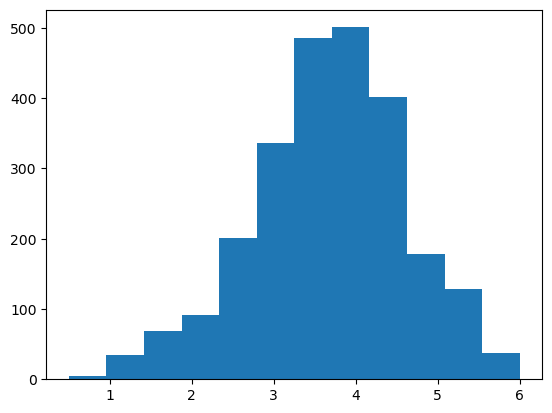

In [265]:
import matplotlib.pyplot as plt

plt.hist(df_labels['score'], bins = 12)
plt.show()

<Axes: xlabel='score'>

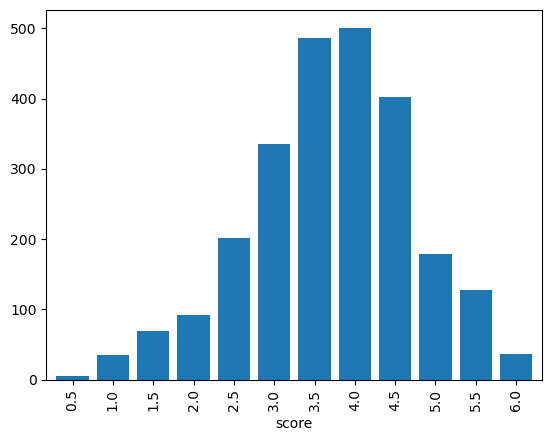

In [266]:
df_labels.groupby('score')['id'].count().plot.bar(width =0.8)

# Preparations for model training

In [267]:
# TO REMOVE

# Assigning classes to scores, where 0.5 is class 1 and 6.0 is class 12
# df_labels['class'] = (df_labels['score']*2).astype(int)
# df_labels.head()

In [268]:
# PLEASE ALSO ADD TEST SET

# Splitting data into train and validation set
# Dropping columns, which are not suitable for training

from sklearn.model_selection import train_test_split
X = df.drop(['id', 'most_frequent_activity'], axis=1)
X = X.fillna(0)

X_test = X[X['is_test'] == True].drop(['is_test'], axis=1)
X = X[X['is_test'] == False].drop(['is_test'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, df_labels['score'], random_state=0, test_size=0.20, stratify = df_labels['score'])

In [269]:
X_train.shape, X_val.shape, X_test.shape

((1976, 26), (495, 26), (3, 26))

In [270]:
# Normalising the data
# More info: https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe

from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_train_normalized.head()

,word_count,event_count,writing_time_min,events_per_min,text_change_count,text_changes_per_min,sentence_count,Input_count,Remove/Cut_count,Paste_count,...,pause_per_min,pauses_share,start_time,end_time,total_writing_time,Avg_time_between_events,overtime_writing,average_action_time,total_characters,avg_characters_per_min
0,0.389992,0.329826,0.298851,0.337839,0.333444,0.341594,0.377778,0.388761,0.195129,0.000000,...,0.526403,0.386364,0.002432,0.299510,0.305057,0.072011,0.0,0.285226,0.360619,0.304500
1,0.131056,0.175918,0.310345,0.170226,0.168092,0.162320,0.177778,0.170076,0.168696,0.000000,...,0.734323,0.545455,0.002003,0.305985,0.311722,0.158024,0.0,0.496442,0.122655,0.094335
2,0.332010,0.260664,0.321839,0.245976,0.263717,0.248924,0.300000,0.325098,0.108999,0.142857,...,0.468647,0.465909,0.050321,0.318256,0.315919,0.102681,1.0,0.266914,0.326381,0.254152
3,0.185068,0.268134,0.287356,0.284830,0.272267,0.289279,0.288889,0.260974,0.306504,0.000000,...,0.447195,0.454545,0.035610,0.287523,0.287163,0.088012,0.0,0.639126,0.165552,0.142801
4,0.227164,0.158487,0.310345,0.152674,0.156470,0.150619,0.200000,0.205470,0.035343,0.000000,...,0.503300,0.568182,0.035976,0.306483,0.306398,0.172731,0.0,0.285790,0.221960,0.177140


In [271]:
X_val_normalized = scaler.transform(X_val)
X_val_normalized = pd.DataFrame(X_val_normalized, columns=X_val.columns)
#X_val_normalized.head()

# Model Training


In [272]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

random_state = np.random.seed(0) # random seed for consistency

RFR = RandomForestRegressor(max_depth=2, random_state=random_state)

RFR.fit(X_train, y_train)

predictions_RFR = RFR.predict(X_val.to_numpy())

/Users/arammul/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [273]:
from sklearn.metrics import accuracy_score, mean_squared_error
rmse_RFR = mean_squared_error(y_val, predictions_RFR, squared = False)
print(rmse_RFR)

0.6912772209327033


In [275]:
predictions = RFR.predict(X_test)
predictions

array([2.38203918, 2.38203918, 2.38203918])

# Submission to Kaggle

In [65]:
df_result = pd.DataFrame({
    "id": df[df['is_test'] == True]['id'],
    "score": predictions
})
df_result

,id,score
2471,0000aaaa,1.0
2472,2222bbbb,1.0
2473,4444cccc,1.0


In [66]:
df_result.to_csv("submission.csv", index=False)